In [1]:
import numpy as np 
import pandas as pd
import os

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import *

from scipy.ndimage import gaussian_filter1d

/home/vitalii_bozheniuk/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def prep_prediction(pred_df, test_df):
    pred = test_df.merge(pred_df, on='ID')
    pred_bins = pred.groupby(['as_of_date_id', 'age_bin_id'])['count'].sum()
    pred_bins = pred_bins.reset_index()
    return pred_bins

In [17]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# step 76 contains an outlier -> drop it
train_filtered = train[(train['as_of_date_id'] != 76) & (train['as_of_date_id'] > 55)] 

# summing all districts and sex groups but keep the data split by age bin
age_bins_grouped = train_filtered.groupby(['as_of_date_id', 'age_bin_id'])['count'].sum()
age_bins_grouped = age_bins_grouped.reset_index()

In the graph below we see clear jumps (which we'll call steps in the code) every 12 timesteps. <br>
We concluded, every time step correspond to a month and the jumps each year reflect that some people move from one age group to another. <br> 
We also see, that within the year (between jumps) the population is linear. <br>
In the test dataset we have to predict population for 13 time steps for all groups. That means we need to predict a jump in the 1st test timestep (ts 118), a line for ts 119-129, and a final jump for ts 130.


age_bin_id
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
Name: count, dtype: object

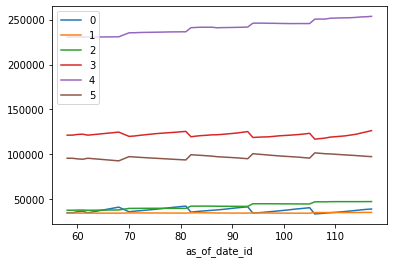

In [19]:
# draw train
age_bins_grouped.set_index('as_of_date_id').groupby('age_bin_id')['count'].plot(legend=True)

In [14]:
%%time 

! python3 synthetic_with_fixed_steps.py

/home/vitalii_bozheniuk/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
CPU times: user 404 ms, sys: 0 ns, total: 404 ms
Wall time: 14.7 s


In [22]:
# load submisison

predictions = pd.read_csv('./data/submisison.csv')
predictions_age_bin = prep_prediction(predictions, test)

In [30]:
import matplotlib.pyplot as plt

In [43]:
age_bins_grouped.set_index('as_of_date_id').groupby('age_bin_id')['count'].gr

In [50]:
from matplotlib import cm
cmap = cm.get_cmap('prism')

In [86]:
colors=['blue', 'orange', 'red', 'brown', 'purple', 'green']

In [79]:
age_bins_ts_data = age_bins_grouped.set_index('as_of_date_id').groupby('age_bin_id')['count'].apply(lambda x: (x.index.tolist(), x.values.tolist()))
predictions_age_bins_ts_data = predictions_age_bin.set_index('as_of_date_id').groupby('age_bin_id')['count'].apply(lambda x: (x.index.tolist(), x.values.tolist()))

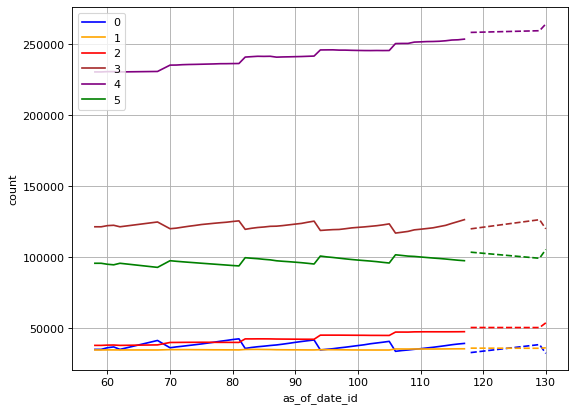

In [100]:
plt.figure(figsize=(8, 6), dpi=80)
plt.ylabel('count')
plt.xlabel('as_of_date_id')

for i in age_bins_ts_data.index:
    color = colors[i]
    plt.plot(age_bins_ts_data.loc[i][0], age_bins_ts_data.loc[i][1], color=color, label=f'{i}')
    plt.plot(predictions_age_bins_ts_data.loc[i][0], predictions_age_bins_ts_data.loc[i][1], '--', color=color)
    
plt.legend(loc='upper left')
plt.grid()